# OGGM-Shop and Glacier Directories in OGGM

## Set-up 

### Input data folders

**If you are using your own computer**: before you start, make sure that you have set-up the [input data configuration file](https://docs.oggm.org/en/stable/input-data.html) at your wish. In the course of this tutorial, we will need to download data needed for each glacier (a couple of mb at max, depending on the chosen glaciers), so make sure you have an internet connection.

### cfg.initialize() and cfg.PARAMS 

An OGGM simulation script will always start with the following commands:

In [1]:
from oggm import cfg, utils
cfg.initialize(logging_level='WARNING')

2021-02-12 13:57:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-12 13:57:49: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-12 13:57:49: oggm.cfg: Multiprocessing: using all available processors (N=8)


A call to [cfg.initialize()](https://docs.oggm.org/en/latest/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some examples of these parameters:

In [2]:
cfg.PARAMS['continue_on_error']

False

In [3]:
cfg.PARAMS['border']

40

In [4]:
cfg.PARAMS['has_internet']

True

## Workflow

In [5]:
import os
from oggm import workflow, tasks

### Working directory 

Each OGGM run needs a **single folder** where to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run. Here we create a temporary folder for you:

In [6]:
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Shop', reset=True)
cfg.PATHS['working_dir']

'/tmp/OGGM/OGGM-Shop'

We use a temporary directory for this example, but in practice you will set this working directory yourself (for example: `/home/john/OGGM_output`. The size of this directory will depend on how many glaciers you'll simulate!

**This working directory is meant to be persistent**, i.e. you can stop your processing workflow after any task, and restart from an existing working directory at a later stage.

### Define the glaciers for the run 

In [7]:
rgi_ids = ['RGI60-01.13696']  # Malaspina glacier (large - hungry in memory)
rgi_ids = ['RGI60-05.00800']  # Glacier in Greenland

You can provide any number of glacier identifiers. You can find other glacier identifiers by exploring the [GLIMS viewer](https://www.glims.org/maps/glims).

For an operational run on an RGI region, you might want to download the [Randolph Glacier Inventory](https://www.glims.org/RGI/) dataset instead, and start from it. This case is covered in the [working with the RGI](working_with_rgi.ipynb) tutorial and in the "Starting from scratch" section below.

### Starting from RGItopo

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the glacier mask task needs the glacier topography data.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/latest/glacierdir.html#glacier-directories). These directories are initialized with the following command (this can take a little while on the first call, as OGGM needs to download some data):

In [8]:
# The RGI version to use
# V62 is an unofficial modification of V6 with only minor, backwards compatible modifications
prepro_rgi_version = 62
# Size of the map around the glacier.
prepro_border = 10
# Degree of processing level. This is OGGM specific and for the shop 1 is the one you want
from_prepro_level = 1
# URL of the preprocessed Gdirs
base_url = 'https://cluster.klima.uni-bremen.de/data/gdirs/dems_v1/default/'

gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=from_prepro_level,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version=prepro_rgi_version,
                                          prepro_border=prepro_border)

2021-02-12 13:58:01: oggm.workflow: init_glacier_directories from prepro level 1 on 1 glaciers.
2021-02-12 13:58:02: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


`gdirs` is a list of [GlacierDirectory](https://docs.oggm.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects (one for each glacier). **Glacier directories are used by OGGM as "file and attribute manager"** for single glaciers. 

For example, we now know where to find the glacier mask files for this glacier:

In [9]:
gdir = gdirs[0]  # take Unteraar
print('Path to the DEM:', gdir.get_filepath('glacier_mask'))

Path to the DEM: /tmp/OGGM/OGGM-Shop/per_glacier/RGI60-05/RGI60-05.00/RGI60-05.00800/glacier_mask.tif


And we can also access some attributes of this glacier:

In [10]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-05.00800
  Region: 05: Greenland
  Subregion: 05-01: Greenland (periphery)           
  Glacier type: Glacier
  Terminus type: Marine-terminating
  Area: 246.825 km2
  Lon, Lat: (-52.141, 66.0945)
  Grid (nx, ny): (176, 158)
  Grid (dx, dy): (200.0, -200.0)

In [11]:
gdir.rgi_date  # date at which the outlines are valid

2000

The advantage of this Glacier Directory data model is that it simplifies greatly the data transfer between tasks. **The single mandatory argument of all entity tasks will allways be a glacier directory**. With the glacier directory, each task will find the input it needs: for example, the glacier outlines are needed for the next plotting function, and are available via the `gdir` argument:

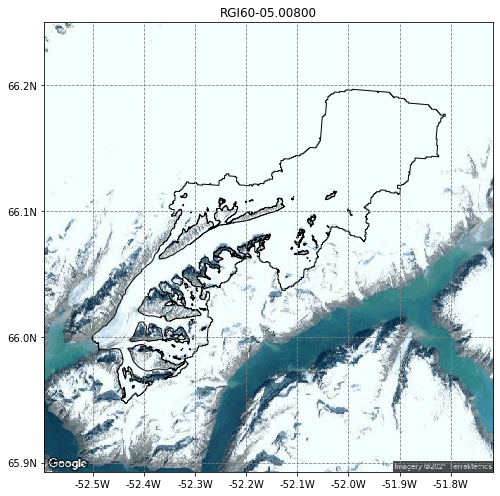

In [12]:
from oggm import graphics
graphics.plot_googlemap(gdir, figsize=(8, 7))

For most glaciers in the world there are several digital elevation models (DEM) which cover the respective glacier. In OGGM we have currently implemented many different open access DEMs to choose from. For some, you need to register to get access, see [dem_sources.ipynb/register](dem_sources.ipynb#register). Some are regional and only available in certain areas (e.g. Greenland or Antarctica) and some cover almost the entire globe. For more information, visit the [rgitools documentation about DEMs](https://rgitools.readthedocs.io/en/latest/dems.html).

### RGItopo data 

In [13]:
sources = [src for src in os.listdir(gdir.dir) if src in utils.DEM_SOURCES]

In [14]:
print('RGI ID:', gdir.rgi_id)
print('Available DEM sources:', sources)

RGI ID: RGI60-05.00800
Available DEM sources: ['DEM3', 'ASTER', 'GIMP', 'COPDEM', 'ARCTICDEM', 'TANDEM', 'MAPZEN', 'AW3D30']


In [15]:
# We use xarray to store the data
import xarray as xr
import numpy as np

ods = xr.Dataset()
for src in sources:
    demfile = os.path.join(gdir.dir, src) + '/dem.tif'
    with xr.open_rasterio(demfile) as ds:
        data = ds.sel(band=1).load() * 1.
        ods[src] = data.where(data > -100, np.NaN)

    sy, sx = np.gradient(ods[src], gdir.grid.dx, gdir.grid.dx)
    ods[src + '_slope'] = ('y', 'x'),  np.arctan(np.sqrt(sy**2 + sx**2))

with xr.open_rasterio(gdir.get_filepath('glacier_mask')) as ds:
    ods['mask'] = ds.sel(band=1).load()

In [16]:
# Decide on the number of plots and figure size
ns = len(sources)
n_col = 3
x_size = 12
n_rows = -(-ns // n_col)
y_size = x_size / n_col * n_rows

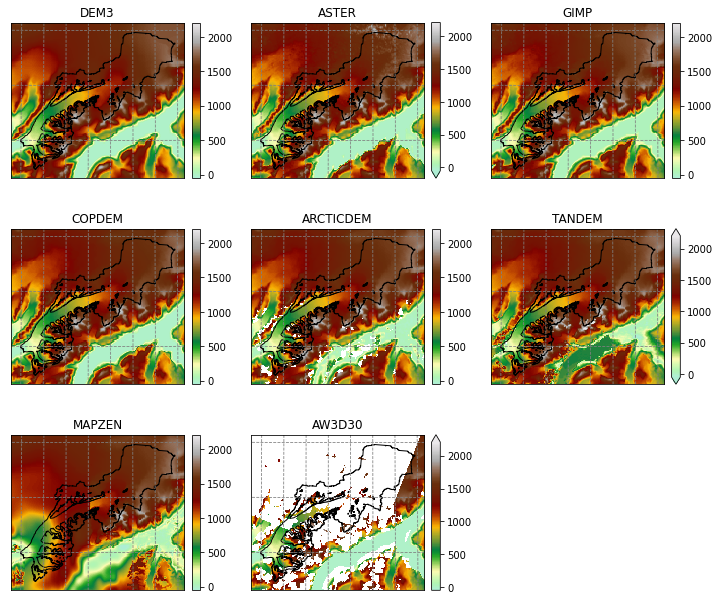

In [17]:
from mpl_toolkits.axes_grid1 import AxesGrid
import salem
import matplotlib.pyplot as plt

smap = salem.graphics.Map(gdir.grid, countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_plot_params(cmap='topo')
smap.set_lonlat_contours(add_tick_labels=False)
smap.set_plot_params(vmin=np.nanquantile([ods[s].min() for s in sources], 0.25),
                     vmax=np.nanquantile([ods[s].max() for s in sources], 0.75))

fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_col),
                axes_pad=0.7,
                cbar_mode='each',
                cbar_location='right',
                cbar_pad=0.1
                )

for i, s in enumerate(sources):
    data = ods[s]
    smap.set_data(data)
    ax = grid[i]
    smap.visualize(ax=ax, addcbar=False, title=s)
    if np.isnan(data).all():
        grid[i].cax.remove()
        continue
    cax = grid.cbar_axes[i]
    smap.colorbarbase(cax)

# take care of uneven grids
if ax != grid[-1]:
    grid[-1].remove()
    grid[-1].cax.remove()

## Original (raw) topography data 

See [dem_sources.ipynb](dem_sources.ipynb).

## OGGM-Shop: ITS-live 

This is an example on how to extract velocity fields from the [ITS_live](https://its-live.jpl.nasa.gov/) Regional Glacier and Ice Sheet Surface Velocities Mosaic ([Gardner, A. et al 2019](http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/documentation/ITS_LIVE-Regional-Glacier-and-Ice-Sheet-Surface-Velocities.pdf)) at 120 m resolution and reproject this data to the OGGM-glacier grid. This only works where ITS-live data is available! (not in the Alps)

In [ ]:
# this will download severals large dataset (2*~800MB)
from oggm.shop import its_live, rgitopo
workflow.execute_entity_task(rgitopo.select_dem_from_dir, gdirs, dem_source='COPDEM', keep_dem_folders=True);
workflow.execute_entity_task(tasks.glacier_masks, gdirs);
workflow.execute_entity_task(its_live.velocity_to_gdir, gdirs);

By applying the entity task [its_live.velocity_to_gdir()](https://github.com/OGGM/oggm/blob/master/oggm/shop/its_live.py#L185) the model downloads and reprojects the ITS_live files to a given glacier map. 

The velocity components (**vx**, **vy**) are added to the `gridded_data` nc file stored on each glacier directory.

According to the [ITS_LIVE documentation](http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/documentation/ITS_LIVE-Regional-Glacier-and-Ice-Sheet-Surface-Velocities.pdf) velocities are given in ground units (i.e. absolute velocities). We then use bilinear interpolation to reproject the velocities to the local glacier map by re-projecting the vector distances.

By specifying `add_error=True`, we also reproject and scale the error for each component (**evx**, **evy**).


Now we can read in all the gridded data that comes with OGGM, including the ITS_Live velocity components.

In [ ]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds

In [ ]:
# plot the salem map background, make countries in grey
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

In [ ]:
# get the wind data at 10000 m a.s.l.
u = ds.obs_icevel_x.where(ds.glacier_mask == 1)
v = ds.obs_icevel_y.where(ds.glacier_mask == 1)
ws = (u**2 + v**2)**0.5

The `ds.glacier_mask == 1` command will remove the data outside of the glacier outline.

In [ ]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

# Quiver only every 3rd grid point
us = u[1::3, 1::3]
vs = v[1::3, 1::3]

smap.set_data(ws)
smap.set_cmap('Blues')
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label = 'ice velocity (m s$^{-1}$)')

# transform their coordinates to the map reference system and plot the arrows
xx, yy = smap.grid.transform(us.x.values, us.y.values, crs=gdir.grid.proj)
xx, yy = np.meshgrid(xx, yy)
qu = ax.quiver(xx, yy, us.values, vs.values)
qk = ax.quiverkey(qu, 0.82, 0.97, 100, '100 m s$^{-1}$',
                   labelpos='E', coordinates='axes')

## OGGM-Shop: bed topography data

In [ ]:
from oggm.shop import bedtopo

In [ ]:
workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdirs);

In [ ]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

In [ ]:
# plot the salem map background, make countries in grey
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))

smap.set_data(ds.consensus_ice_thickness)
smap.set_cmap('Blues')
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice thickness (m)');

## OGGM-Shop: climate data

In [ ]:
# TODO

## What's next?

- look at the [OGGM-Shop documentation](https://docs.oggm.org/en/latest/input-data.html#)
- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)